In [1]:
import json
import os
import os.path as osp
import numpy as np
import cv2
from PIL import Image
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

import torch.utils.data as data

# 데이터셋과 데이터로더 구현
## 경로 리스트 작성

In [3]:
def make_datapath_list(rootpath):
    json_path = osp.join(rootpath, "COCO.json")
    with open(json_path) as data_file:
        data_this = json.load(data_file)
        data_json = data_this["root"]

    num_samples = len(data_json)
    train_indexes = []
    val_indexes = []
    for count in range(num_samples):
        if data_json[count]["isValidation"] != 0.:
            val_indexes.append(count)
        else:
            train_indexes.append(count)

    train_img_list = list()
    val_img_list = list()

    for idx in train_indexes:
        img_path = os.path.join(rootpath, data_json[idx]["img_paths"])
        train_img_list.append(img_path)
    
    for idx in val_indexes:
        img_path = os.path.join(rootpath, data_json[idx]["img_paths"])
        val_img_list.append(img_path)

    train_mask_list = []
    val_mask_list = []

    for idx in train_indexes:
        img_idx = data_json[idx]["img_paths"][-16:-4]
        anno_path = "./data/mask/train2014/mask_COCO_train2014_"+img_idx+".jpg"
        train_mask_list.append(anno_path)
    
    for idx in val_indexes:
        img_idx = data_json[idx]["img_paths"][-16:-4]
        anno_path = "./data/mask/val2014/mask_COCO_val2014_"+img_idx+".jpg"
        val_mask_list.append(anno_path)

    train_meta_list = list()
    val_meta_list = list()

    for idx in train_indexes:
        train_meta_list.append(data_json[idx])

    for idx in val_indexes:
        val_meta_list.append(data_json[idx])

    return train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list

train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list = make_datapath_list(rootpath="./data/")

In [4]:
val_meta_list[24]

{'dataset': 'COCO_val',
 'isValidation': 1.0,
 'img_paths': 'val2014/COCO_val2014_000000000488.jpg',
 'img_width': 640.0,
 'img_height': 406.0,
 'objpos': [233.075, 275.815],
 'image_id': 488.0,
 'bbox': [180.76, 210.3, 104.63, 131.03],
 'segment_area': 4851.846,
 'num_keypoints': 15.0,
 'joint_self': [[266.0, 231.0, 1.0],
  [0.0, 0.0, 2.0],
  [264.0, 229.0, 1.0],
  [0.0, 0.0, 2.0],
  [256.0, 231.0, 1.0],
  [261.0, 239.0, 1.0],
  [238.0, 239.0, 1.0],
  [267.0, 259.0, 1.0],
  [222.0, 262.0, 1.0],
  [272.0, 267.0, 1.0],
  [243.0, 256.0, 1.0],
  [244.0, 278.0, 1.0],
  [229.0, 279.0, 1.0],
  [269.0, 297.0, 1.0],
  [219.0, 310.0, 1.0],
  [267.0, 328.0, 1.0],
  [192.0, 329.0, 1.0]],
 'scale_provided': 0.356,
 'joint_others': [[[0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [174.0, 261.0, 1.0],
   [169.0, 275.0, 1.0],
   [155.0, 275.0, 1.0],
   [190.0, 282.0, 1.0],
   [142.0, 299.0, 1.0],
   [217.0, 285.0, 1.0],
   [133.0, 329.0, 1.0],
   [0.0, 0.0, 2.0],
   [

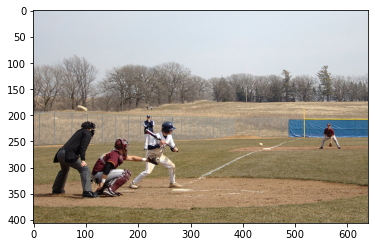

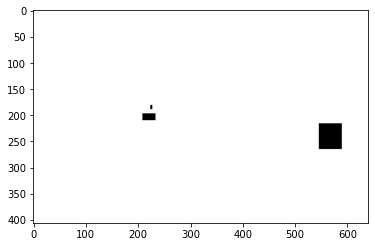

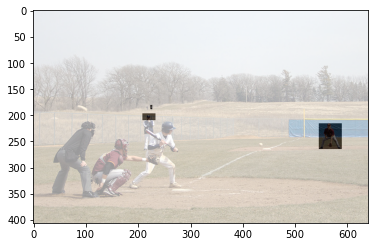

In [5]:
index = 24

img = cv2.imread(val_img_list[index])
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

mask_miss = cv2.imread(val_mask_list[index])
mask_miss = cv2.cvtColor(mask_miss, cv2.COLOR_BGR2RGB)
plt.imshow(mask_miss)
plt.show()

blend_img = cv2.addWeighted(img, 0.4, mask_miss, 0.6,0)
plt.imshow(blend_img)
plt.show()

## 화상 전처리 작성

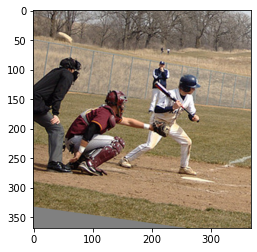

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


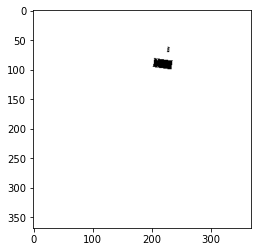

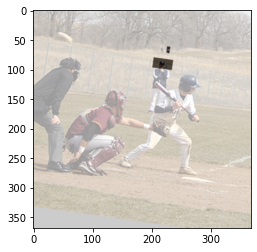

In [6]:
from utils.data_augumentation import *

class DataTransform():
    def __init__(self):
        self.data_transform = {
            "train":Compose([
                get_anno(),
                add_neck(),
                aug_scale(),
                aug_rotate(),
                aug_croppad(),
                aug_flip(),
                remove_illegal_joint(),
                no_Normalize_Tensor()
            ]),
            "val" : Compose([

            ])
        }
    def __call__(self, phase, meta_data, img, mask_miss):
        meta_data, img, mask_miss = self.data_transform[phase](meta_data, img, mask_miss)

        return meta_data, img, mask_miss

index = 24
img = cv2.imread(val_img_list[index])
mask_miss = cv2.imread(val_mask_list[index])
meta_data = val_meta_list[index]

transform = DataTransform()
meta_data, img, mask_miss = transform("train", meta_data, img, mask_miss)

img = img.numpy().transpose((1,2,0))
plt.imshow(img)
plt.show()

mask_miss = mask_miss.numpy().transpose((1,2,0))
plt.imshow(mask_miss)
plt.show()

img = Image.fromarray(np.uint8(img*255))
img = np.asarray(img.convert("RGB"))
mask_miss = Image.fromarray(np.uint8((mask_miss)))
mask_miss = np.asarray(mask_miss.convert("RGB"))
blend_img = cv2.addWeighted(img, 0.4, mask_miss, 0.6, 0)
plt.imshow(blend_img)
plt.show()